In [1]:
import sys
import os
sys.path.append("/export/home1/users/bssn/serna/GitIBENS/Nanorods")
from numpy import *
from matplotlib.pylab import *
import scipy.optimize as opt
import pickle
from scipy.optimize import minimize,least_squares
from scipy.stats import linregress

%matplotlib inline
from signal_analysis.core import dblgausfit,dblgaussd
from sub.cor2img import transfpar,coincidROI
from tools.extracting_ROIfrommovie import extractROIS,fitRois
import warnings
warnings.simplefilter("ignore")

basef = "/mnt/data/Anastasia/"
wdirsG = ["/mnt/data/Anastasia/Glass"]

wdirs = wdirsG
dfiles = []
for dirt in wdirs:
    basedir = dirt
    files = os.listdir(basedir)
    if dirt[-1] != '/':
        dirt = dirt+'/'
    for f in files:
        if f[-4:]=='.tif': 
            try:
                i = int(f[-5])
                dfiles.append(dirt+f)
            except:
                pass

dfiles.pop(1)
     
               
  
            
#dfiles = dfiles[4:8]

print(len(dfiles))
print(dfiles)


3
['/mnt/data/Anastasia/Glass/field1_2.tif', '/mnt/data/Anastasia/Glass/field2_4.tif', '/mnt/data/Anastasia/Glass/field3_6.tif']


In [2]:
dataL = []
nwdirs = []
for i,cfile in enumerate(dfiles):
    wdir = ''
    cf2 = cfile.split(".")[0].split("/")
    for fs in cf2[:-1]:
        wdir = wdir+fs+'/'
    wdir = wdir+cf2[-1]+'output/sptrack/'
    nwdirs.append(wdir)
    
    #with open(wdir+'data_msd.pickle', 'rb') as handle:
    #    datat = pickle.load(handle)
    
    #dataL.append(datat)
print(nwdirs,len(dataL))

dfilesF = []
dfilesPA = []
dfilesFPA = []
dfilesFPB = []

dfilesPB = []
driftcorrected = True
for i,dirt in enumerate(nwdirs):
    basedir = dirt
    dfilesPA.append(basedir+'../posA.dat')
    dfilesFPA.append(basedir+'../FposA.dat')
    dfilesPB.append(basedir+'../posB.dat')
    dfilesFPB.append(basedir+'../FposB.dat')

    try:
        files = os.listdir(basedir)
        dfilest = []
        if driftcorrected:
            #print(files[0])
            for f in files:

                if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]=='DC': dfilest.append(basedir+f)
        else:
            for f in files:
                if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]!='DC': dfilest.append(basedir+f)
    except:
        pass
    dfilest.sort()
    dfilesF.extend(dfilest)
    
dfilesPA.sort()
dfilesPB.sort()
print(dfilesPA)
    


['/mnt/data/Anastasia/Glass/field1_2output/sptrack/', '/mnt/data/Anastasia/Glass/field2_4output/sptrack/', '/mnt/data/Anastasia/Glass/field3_6output/sptrack/'] 0
['/mnt/data/Anastasia/Glass/field1_2output/sptrack/../posA.dat', '/mnt/data/Anastasia/Glass/field2_4output/sptrack/../posA.dat', '/mnt/data/Anastasia/Glass/field3_6output/sptrack/../posA.dat']


In [3]:
dfilesFPt = [f for f in dfilesFPA]
dfilesFPt.extend(dfilesFPB)
idRois = []
posRois = []
idxfile = []
idifile = []
count = 0
for i in range(len(dfilesFPt)):
    pos0 = array(loadtxt(dfilesFPt[i]))
    posRois.append(array(pos0,dtype=int))
    idxfile.extend(array(ones(pos0.shape[0])*i,dtype=int).tolist())
    idifile.extend(array(zeros(pos0.shape[0]) + count,dtype=int).tolist())
    count +=pos0.shape[0]

In [4]:
len(idifile)

8862

In [5]:
with open('/mnt/data/Anastasia/glass_stats.pkl','rb') as f:
    _,_,_,_,idx0,_,_,_,_,_ = pickle.load(f)


In [6]:
id00 = 2000
def ROIfilename(id00):
    id0 = idx0[id00]
    wdirt = dfilesFPt[idxfile[id0]].split('..')[0]
    if idxfile[id0]<3:
        channel = 'A'
    else:
        channel = 'B'
    id0 = id0-idifile[id0]
    return(wdirt+'posh_roi_s'+channel+str(id0).zfill(4)+'_DC.npy')

print(ROIfilename(8855))

/mnt/data/Anastasia/Glass/field3_6output/sptrack/posh_roi_sB0999_DC.npy


Now we need to fit to gaussians this ROIS too, the most likely case is that it was not done before. They do not blink, so they should not have passed the test.


We need to add the function extractROIS from Nanorods/tools

In [7]:
def running_mean(x, N):
    cumsumt = cumsum(insert(x, 0, 0)) 
    return (cumsumt[N:] - cumsumt[:-N]) / float(N)


In [8]:
def driftSingle(popts,th =0.0,th2 = 13.0,minlength=1000):
    posx = popts[:,5]
    posy = popts[:,6]
    amp = popts[:,0]
    ampbg = popts[:,0]/popts[:,4]
     

    sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    if sel.sum()>minlength:
        dx = posx[sel][1:]-posx[sel][:-1]
        dy = posy[sel][1:]-posy[sel][:-1]
        return([dx.mean(),dy.mean(),amp[sel].mean(),dx.std(),dy.std(),ampbg[sel].mean()])
    else:
        return([nan,nan,nan,nan,nan,nan])
        


In [9]:
def plot_trajectory(x,y,trace=True, fig = None, ax = None):
    ts = arange(x.shape[0])
    tsr = ts*10e-3
        
        
    mex = mean(x); sdx = std(x)
    xlims =[ floor(10*(mex-2*sdx)*.98)/10.0,ceil(10*(mex+2*sdx)*1.02)/10.0]
    mey = mean(y); sdy = std(y)

    ylims =[ floor(10*(mey-2*sdy)*.98)/10.0,ceil(10.0*(mey+2*sdy)*1.02)/10.0]
    
    npixelx = floor(xlims[1]-xlims[0])+1
    npixely = floor(ylims[1]-ylims[0])+1
    npixell = max(npixelx,npixely)
    npixelx = npixell
    npixely = npixell
    xwdthleft = npixelx-(xlims[1]-xlims[0])
    ywdthleft = npixely-(ylims[1]-ylims[0])
    xlims[0] = xlims[0]-xwdthleft/2.0
    xlims[1] = xlims[1]+xwdthleft/2.0
    ylims[0] = ylims[0]-ywdthleft/2.0
    ylims[1] = ylims[1]+ywdthleft/2.0
    
    scdiv = 325/20.0

    nf = 50
    ns = 50
    k = len(x)
    xm = running_mean(x,ns)
    ym = running_mean(y,ns)
    
    if ax is None:
        ax = plt.gca()
    #ax = fig.add_subplot(111)
    sc = ax.scatter(x,y,c=tsr,cmap=cmapgnu,alpha=0.5)
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_ylim(ylims[0],ylims[1])
    ax.axis('off')
    ax.plot([xlims[1]*0.99-1.0/scdiv,xlims[1]*0.99],[ylims[0]*1.01,ylims[0]*1.01],'k-',linewidth=2.0)
    ax.text(xlims[1]*0.99-.70/scdiv,ylims[0]*1.013,"20nm")
    sc.set_clim(0,len(x)*10e-3)

    ax.set_xlabel("pixel")
    ax.set_ylabel("pixel")

    if trace:
        ax.plot(xm,ym,'-',c='C0',alpha=0.7)
    

In [10]:
cmapgnu = get_cmap("gnuplot")


In [13]:

def plotNR(x,y,tsr,ax):
    mex = mean(x) 
    sdx = std(x)
    xlims =[ floor(10*(mex-2*sdx)*.98)/10.0,ceil(10*(mex+2*sdx)*1.02)/10.0]
    mey = mean(y)
    sdy = std(y)

    ylims =[ floor(10*(mey-2*sdy)*.98)/10.0,ceil(10.0*(mey+2*sdy)*1.02)/10.0]

    npixelx = floor(xlims[1]-xlims[0])+1
    npixely = floor(ylims[1]-ylims[0])+1
    npixell = max(npixelx,npixely)
    npixelx = npixell
    npixely = npixell
    xwdthleft = npixelx-(xlims[1]-xlims[0])
    ywdthleft = npixely-(ylims[1]-ylims[0])
    xlims[0] = xlims[0]-xwdthleft/2.0
    xlims[1] = xlims[1]+xwdthleft/2.0
    ylims[0] = ylims[0]-ywdthleft/2.0
    ylims[1] = ylims[1]+ywdthleft/2.0

    scdiv = 325/20.0

    nf = 50
    ns = 50
    k = len(x)
    xm = running_mean(x,ns)
    ym = running_mean(y,ns)

    #ax = fig.add_subplot(111)
    #print(x.shape,y.shape,tsr.shape)
    sc = ax.scatter(x,y,c=tsr,cmap=cmapgnu,alpha=0.5)
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_ylim(ylims[0],ylims[1])
    ax.axis('off')
    ax.plot([xlims[1]*0.99-1.0/scdiv,xlims[1]*0.99],[ylims[0]*1.01,ylims[0]*1.01],'k-',linewidth=2.0)
    ax.text(xlims[1]*0.99-.70/scdiv,ylims[0]*1.013,"20nm")
    sc.set_clim(0,len(x)*10e-3)
    #axc = colorbar()
    #axc.set_label("t(s)")
    ax.set_xlabel("pixel")
    ax.set_ylabel("pixel")
    subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
        hspace = 0, wspace = 0)
    ax.margins(0,0)
    ax.text((xlims[0]+xlims[1])*.5,ylims[1]-(ylims[1]-ylims[0])*.05,"NR "+str(i),fontsize=14)
    ax.plot(xm,ym,'-',c='C0',alpha=0.7)
    

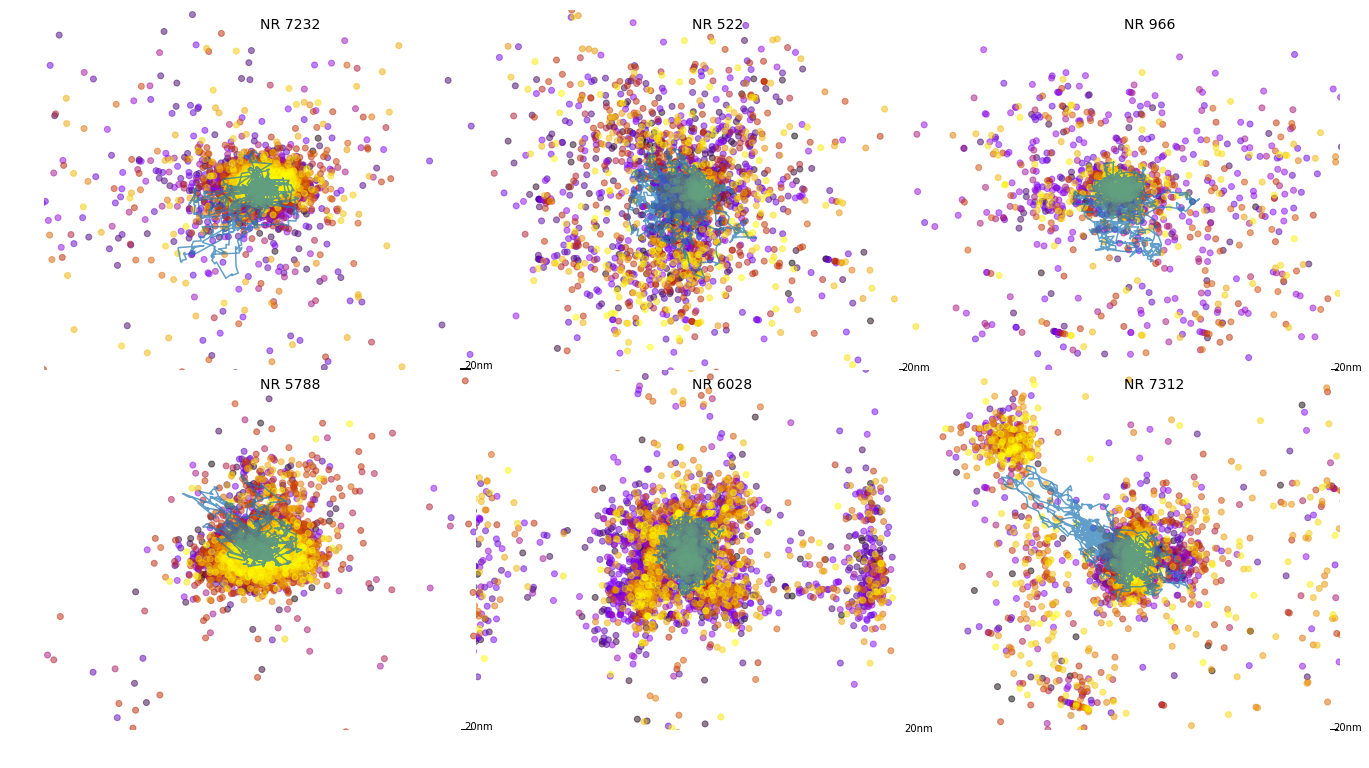

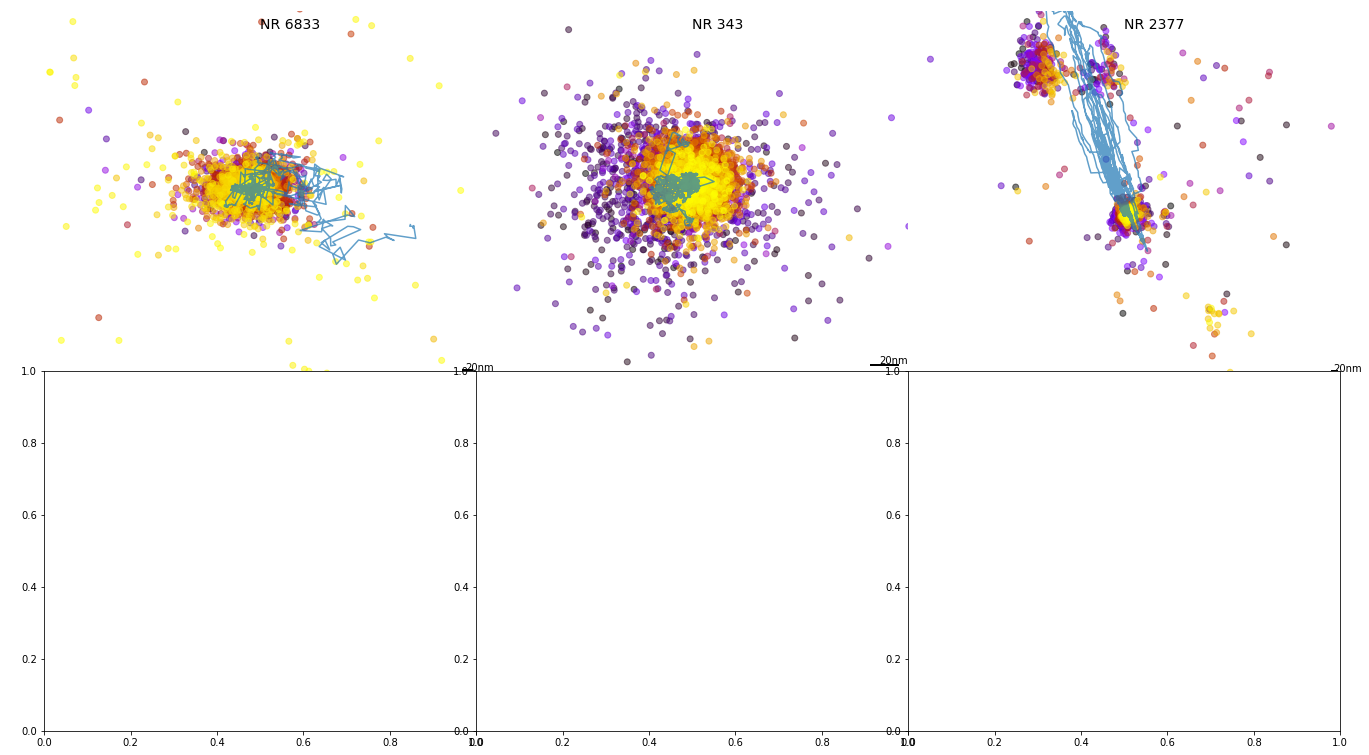

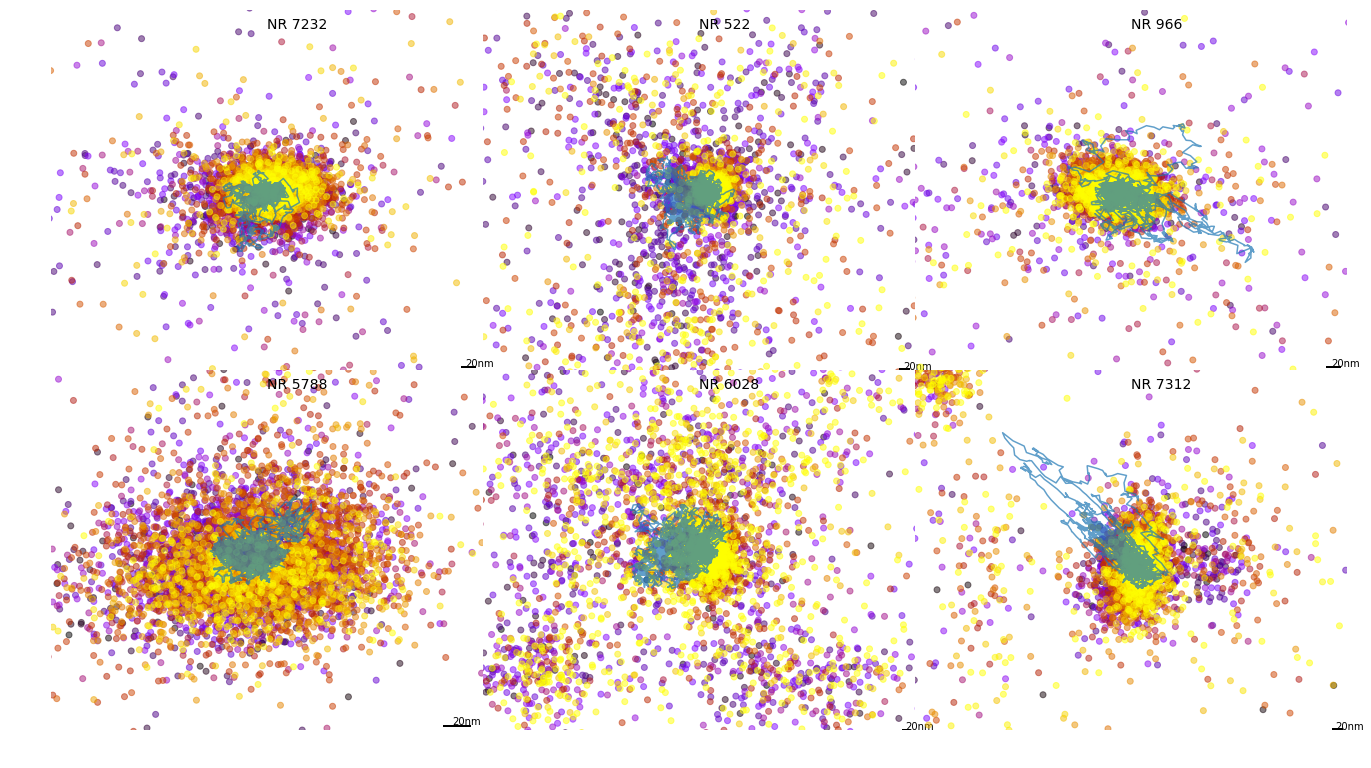

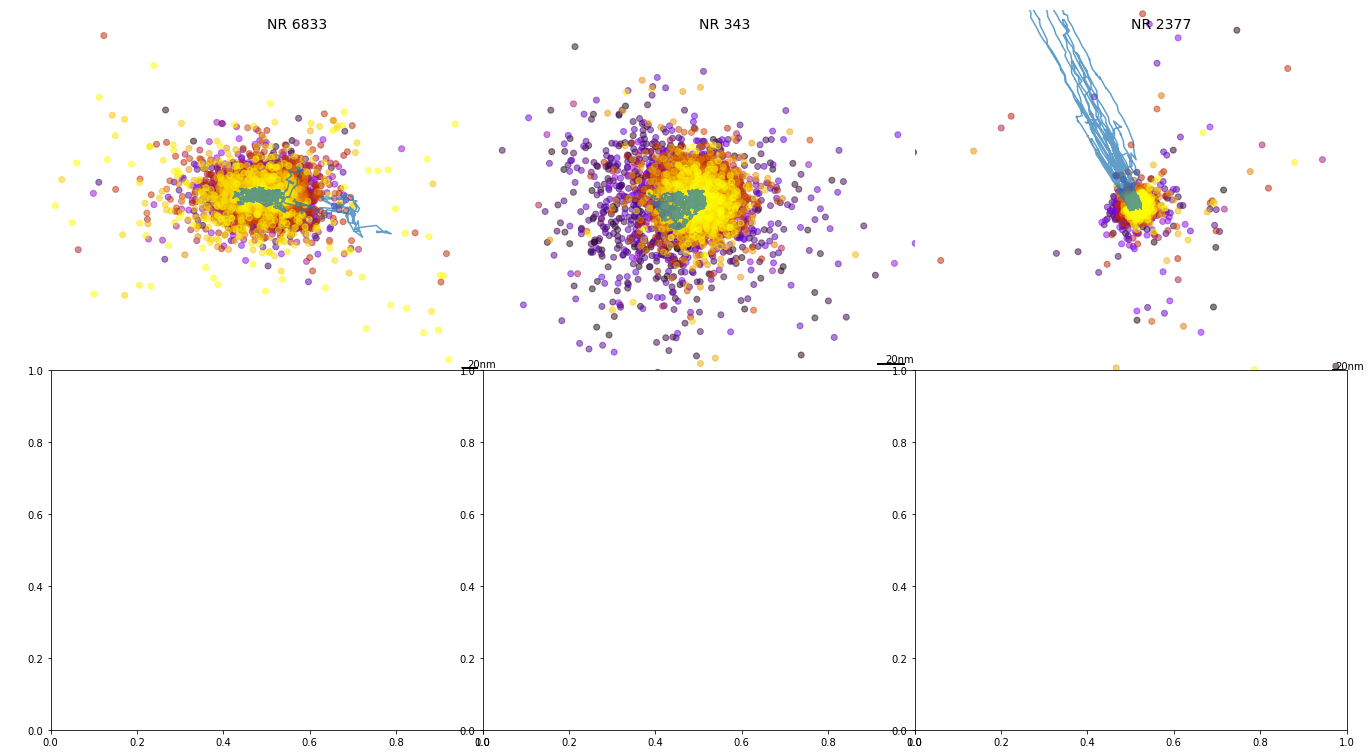

In [14]:
ids = [7232,522,966,5788, 6028, 7312,6833,  343, 2377]

id6 = (len(ids)-1)//6
for i6 in range(id6+1*(len(ids)%6!=0)):
    fig, axs = subplots(nrows=2,ncols=3,figsize=(18,10))

    for k,i in enumerate(ids[(6*i6):(6*i6+6)]):
        popts = load(ROIfilename(i))
        posx = popts[:,5]
        posy = popts[:,6]
        amp = popts[:,0]
        th = 0
        th2 = 13.0
        sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
        Tf = len(posx)

        
        ax = axs[k//3,k%3]
        x = posx
        y = posy
        ts = arange(x.shape[0])
        tsr = ts*10e-3


        plotNR(x,y,tsr,ax)
        
for i6 in range(id6+1*(len(ids)%6!=0)):
    fig, axs = subplots(nrows=2,ncols=3,figsize=(18,10))

    for k,i in enumerate(ids[(6*i6):(6*i6+6)]):
        popts = load(ROIfilename(i))
        posx = popts[:,5]
        posy = popts[:,6]
        amp = popts[:,0]
        th = 0
        th2 = 13.0
        sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
        Tf = len(posx)

        
        ax = axs[k//3,k%3]
        x = posx
        y = posy
        ts = arange(x.shape[0])
        tsr = ts*10e-3

        x = x[sel]
        y = y[sel]
        tsr = tsr[sel]
        plotNR(x,y,tsr,ax)

## First Remarks
We do need to remove those blinking states... Arggggg
- First let's extract MSD
- Then do the same with cleaned version
- Check differences.

In [18]:
from sptrack.msdestimate_longer import msdestimate as msdestimate0
from signal_analysis.core import dblgausfit,dblgaussd


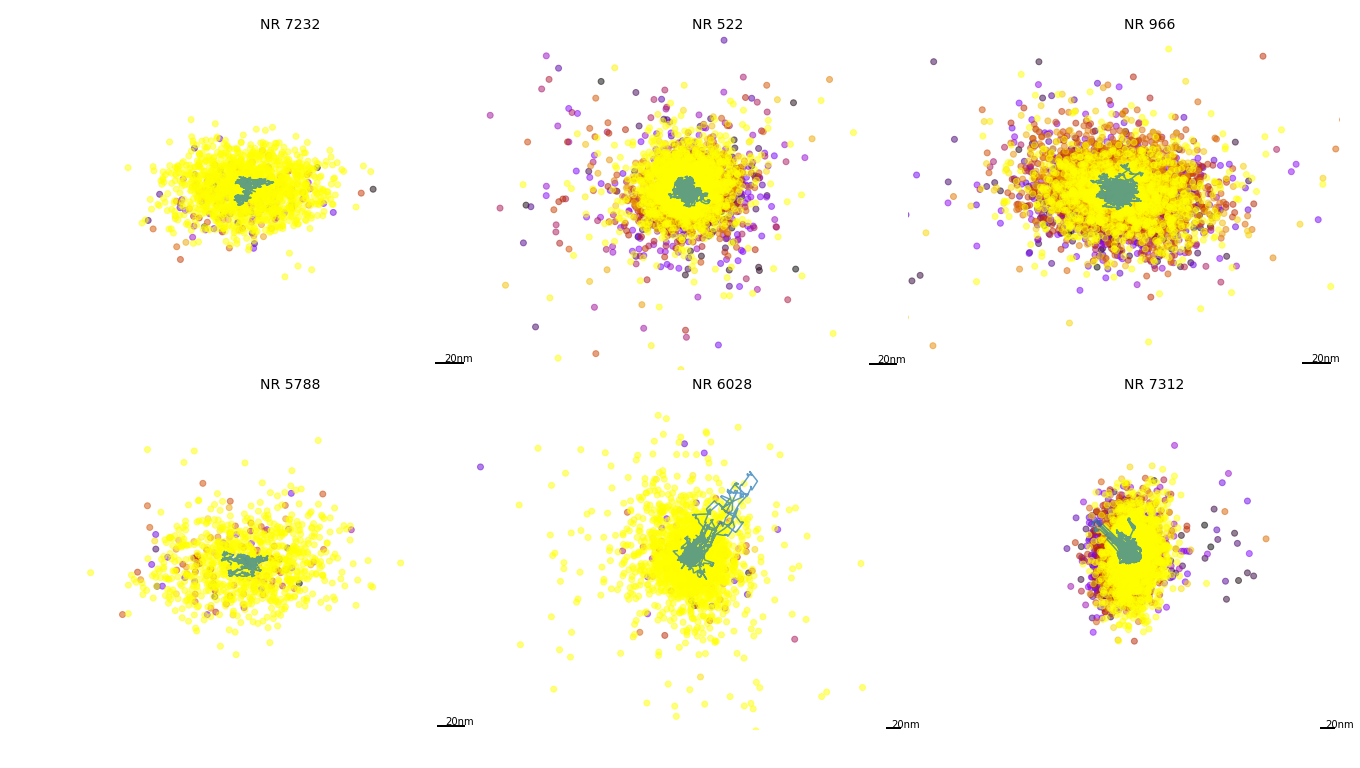

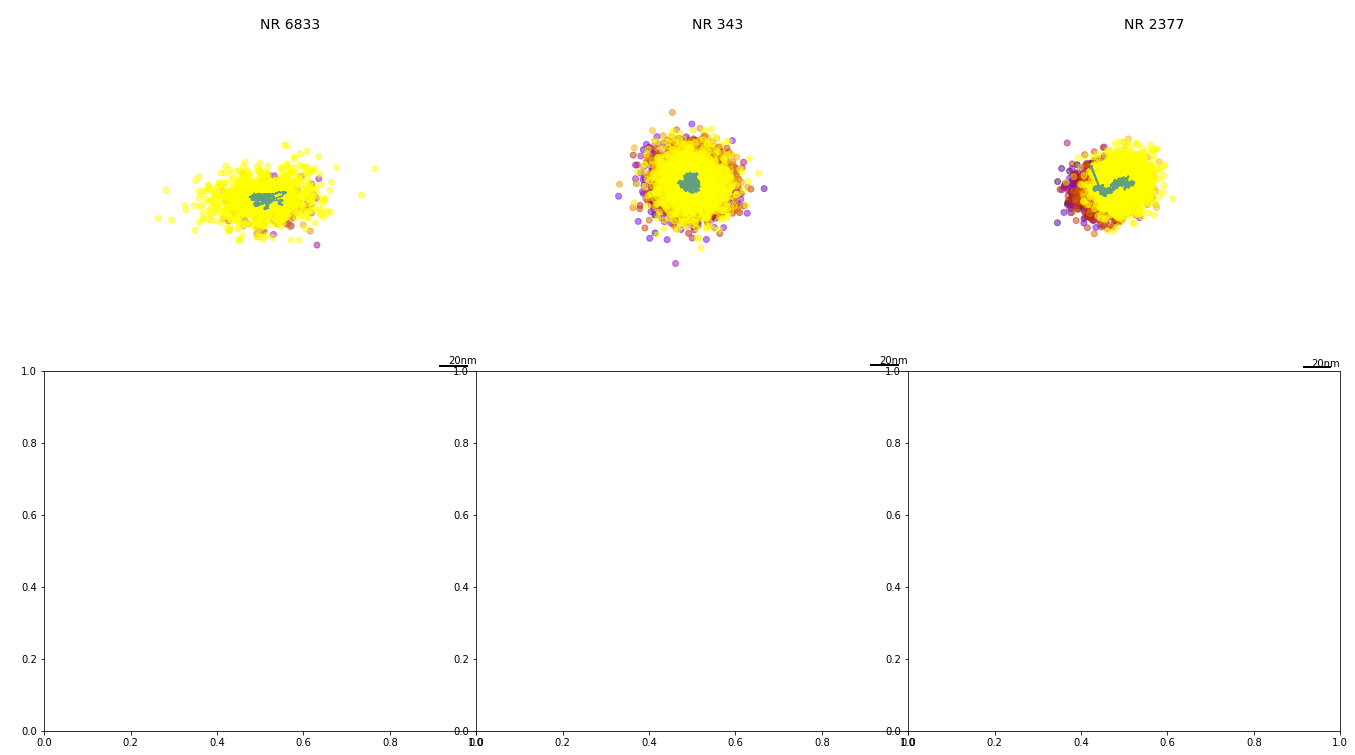

In [35]:
for i6 in range(id6+1*(len(ids)%6!=0)):
    fig, axs = subplots(nrows=2,ncols=3,figsize=(18,10))

    for k,i in enumerate(ids[(6*i6):(6*i6+6)]):
        popts = load(ROIfilename(i))
        posx = popts[:,5]
        posy = popts[:,6]
        amp = popts[:,0]
        th = 0
        th2 = 13.0
        sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
        Tf = len(posx)

        
        ax = axs[k//3,k%3]
        x = posx
        y = posy
        ts = arange(x.shape[0])
        tsr = ts*10e-3
        if True:
            m1,m2 = (mean(amp[sel]),std(amp[sel]))
            amb = (amp-m1)/m2
            am = (amp[sel]-m1)/m2
            h = histogram(am,arange(min(am),max(am),0.2))
            hd = h[0]/sum(h[0])/0.2
            hx = (h[1][1:]+h[1][:-1])/2.0
            dgfit = dblgausfit(hx,hd,par0=array([0.5,-1,.5,1,.5]))
            dgt = concatenate(([m1,m2],dgfit.x))
            s1 = max(dgt[6],dgt[4])
            yt = abs((dgt[3]-dgt[5])/s1)
            if dgt[5]<dgt[3]:
                temp= ()
            if True:
                #sel = sel*(amb>max(dgt[5]-2*dgt[6],dgt[3]-2*dgt[4]))
                sel = sel*(amb>min(dgt[5]+2*dgt[6],dgt[3]+2*dgt[4]))
                
        x = x[sel]
        y = y[sel]
        tsr = tsr[sel]
        plotNR(x,y,tsr,ax)

0.8102565358849544
0.4587880142405495 17.439549016175697 6.977278820430259 68.60057902148971 63.14176774820634
-0.981976699772634


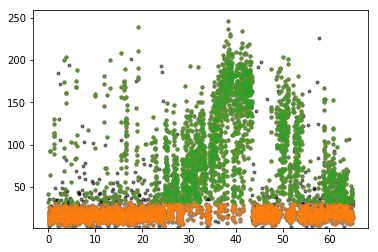

In [36]:
i = 6028
popts = load(ROIfilename(i))
posx = popts[:,5]
posy = popts[:,6]
amp = popts[:,0]
th = 0
th2 = 13.0
sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
Tf = len(posx)


ax = axs[k//3,k%3]
x = posx
y = posy
ts = arange(x.shape[0])
tsr = ts*10e-3
plot(tsr,amp,'k.',alpha=0.5)
plot(tsr[sel],amp[sel],'.',alpha=0.5)
ylim(min(amp[sel])*.95,max(amp[sel])*1.05)
m1,m2 = (mean(amp[sel]),std(amp[sel]))
amb = (amp-m1)/m2
am = (amp[sel]-m1)/m2
h = histogram(am,arange(min(am),max(am),0.2))
hd = h[0]/sum(h[0])/0.2
hx = (h[1][1:]+h[1][:-1])/2.0
dgfit = dblgausfit(hx,hd,par0=array([0.5,-1,.5,1,.5]))
dgt = concatenate(([m1,m2],dgfit.x))
s1 = max(dgt[6],dgt[4])
yt = abs((dgt[3]-dgt[5])/s1)
print(yt)
sel = sel*(amb>max(dgt[5]-2*dgt[6],dgt[3]-2*dgt[4]))
plot(tsr[sel],amp[sel],'.',alpha=0.5)
sel = sel*(amb>min(dgt[5]+2*dgt[6],dgt[3]+2*dgt[4]))
plot(tsr[sel],amp[sel],'.',alpha=0.5)
print(dgfit.x[0],dgfit.x[1]*m2+m1,dgfit.x[2]*m2,dgfit.x[3]*m2+m1,dgfit.x[4]*m2)
print(max(dgt[5]-2*dgt[6],dgt[3]-2*dgt[4]))

In [41]:
def msdestimate(name,th = 0, th2 = 15.0,twoG = False):
    popts = load(name)
    posx = popts[:,5]
    posy = popts[:,6]
    amp = popts[:,0]
    sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    Tf = len(posx)
    
    if sel.sum() > 1000:
        if twoG:
            m1,m2 = (mean(amp[sel]),std(amp[sel]))
            amb = (amp-m1)/m2
            am = (amp[sel]-m1)/m2
            h = histogram(am,arange(min(am),max(am),0.2))
            hd = h[0]/sum(h[0])/0.2
            hx = (h[1][1:]+h[1][:-1])/2.0
            dgfit = dblgausfit(hx,hd,par0=array([0.5,-1,.5,1,.5]))
            dgt = concatenate(([m1,m2],dgfit.x))
            s1 = max(dgt[6],dgt[4])
            yt = abs((dgt[3]-dgt[5])/s1)
            if dgt[5]<dgt[3]:
                temp= ()
            
            sel2 = sel*(amb>min(dgt[5]+2*dgt[6],dgt[3]+2*dgt[4]))
            if sel2.sum()<500:
                sel2 = sel*(amb>max(dgt[5]-2*dgt[6],dgt[3]-2*dgt[4]))
            if sel2.sum()>500:
                sel = sel2
        
        #ts is the index of posx, posy
        ts = arange(Tf)[sel]
        Tfn = ts[-1]
        lp = sum(sel)
        

        tmax = popts.shape[0]//2
        msd = zeros(tmax)
        msd2 = zeros(tmax)
        cnt = zeros(tmax)
        for i,t in enumerate(ts[:-5]):
            #print(i,t)
            # For each i, and and t (= i or i+ #dropped frames)
            # we get i2 = i + maximum time used to estimate MSD 
            # clipped to the array length
            i2 = min(i+tmax,lp)
            # Now we get the indices for them
            sel = ts[i:i2]
            # Difference in time for those indices
            t2 = ts[i:i2]-t
            # We keep only indices for those s
            sel = sel[t2<tmax]
            t2 = t2[t2< tmax]
            
            xs = posx[sel]
            ys = posy[sel]
            msd[t2] += (xs-xs[0])**2+(ys-ys[0])**2
            msd2[t2] += ((xs-xs[0])**2+(ys-ys[0])**2)**2
            cnt[t2] += 1

        #t = arange(tmax)

        msd01 = array(msd/cnt)
        msd01b = array(msd2/cnt)
        cnt01 = array(cnt)
        return(msd01,msd01b,cnt01)

In [43]:
msd01,msd01b, cnt01 = msdestimate(ROIfilename(i))
msd02,msd02b, cnt02 = msdestimate(ROIfilename(i),twoG=True)

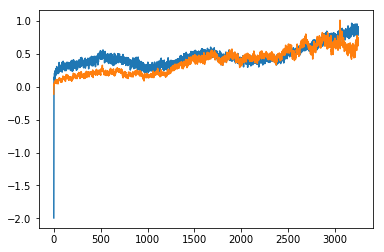

In [49]:
plot(msd01-msd01[1])
plot(msd02-msd02[1])